In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

In [13]:
# 1. Carga de datos
# ------------------------------
# Leer el archivo CSV que contiene los datos de compra/alquiler
datos = pd.read_csv('comprar_alquilar.csv')

print("Primeras filas del dataset:")
print(datos.head())

print("\nInformación del dataset:")
print(datos.info())

print("\nEstadísticas descriptivas:")
print(datos.describe())

print("\nDistribución de la variable 'comprar':")
print(datos['comprar'].value_counts())

Primeras filas del dataset:
   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   

   estado_civil  hijos  trabajo  comprar  
0             0      2        2        1  
1             1      3        6        0  
2             2      1        8        1  
3             0      0        3        0  
4             0      0        3        1  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ingresos        202 non-null    int

In [14]:
# 3. Preprocesamiento de datos
# ------------------------------
# Codificar variables categóricas (one-hot encoding)
datos = pd.get_dummies(datos, columns=['estado_civil', 'trabajo'], drop_first=True)

# Separar características (X) y variable objetivo (y)
X = datos.drop('comprar', axis=1)
y = datos['comprar']

# Estandarizar los datos (media=0, varianza=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# 4. Reducción de dimensionalidad con PCA (2 componentes)
# -------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\nVarianza explicada por cada componente:")
print(pca.explained_variance_ratio_)


Varianza explicada por cada componente:
[0.15810589 0.13029571]


In [16]:
# 5. Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

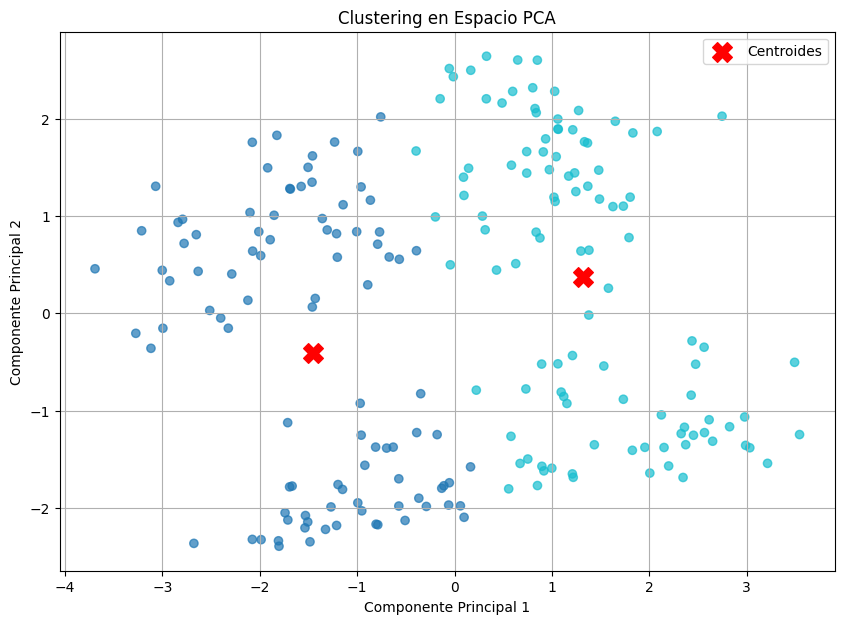

In [17]:
# 6. Análisis de clustering (K-Means)
# -------------------------------------------------
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X', label='Centroides')
plt.title('Clustering en Espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid()
plt.show()

In [18]:
# 7. Interpretación de componentes
# -------------------------------------------------
componentes = pd.DataFrame(pca.components_, 
                          columns=X.columns,
                          index=['PC1', 'PC2'])
print("\nCargas de los componentes principales:")
print(componentes)


Cargas de los componentes principales:
     ingresos  gastos_comunes  pago_coche  gastos_otros   ahorros  vivienda  \
PC1  0.535165        0.334755   -0.135100     -0.112105  0.485386  0.466367   
PC2  0.145279        0.063048   -0.095657      0.083709  0.167977 -0.001553   

        hijos  estado_civil_1  estado_civil_2  trabajo_1  trabajo_2  \
PC1 -0.156075        0.082167       -0.199216   0.048195  -0.025627   
PC2  0.587613        0.374151        0.146475  -0.255308  -0.245852   

     trabajo_3  trabajo_4  trabajo_5  trabajo_6  trabajo_7  trabajo_8  
PC1   0.122307   0.053748   0.022110  -0.054158  -0.111197  -0.101036  
PC2  -0.226607  -0.223968   0.277603   0.185792   0.185440   0.225172  


In [19]:
# 8. Guardado de modelos
# -------------------------------------------------
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

print("\nModelos guardados exitosamente:")
print("- pca_model.pkl (modelo PCA)")
print("- scaler.pkl (normalizador)")
print("- kmeans_model.pkl (modelo K-Means)")


Modelos guardados exitosamente:
- pca_model.pkl (modelo PCA)
- scaler.pkl (normalizador)
- kmeans_model.pkl (modelo K-Means)


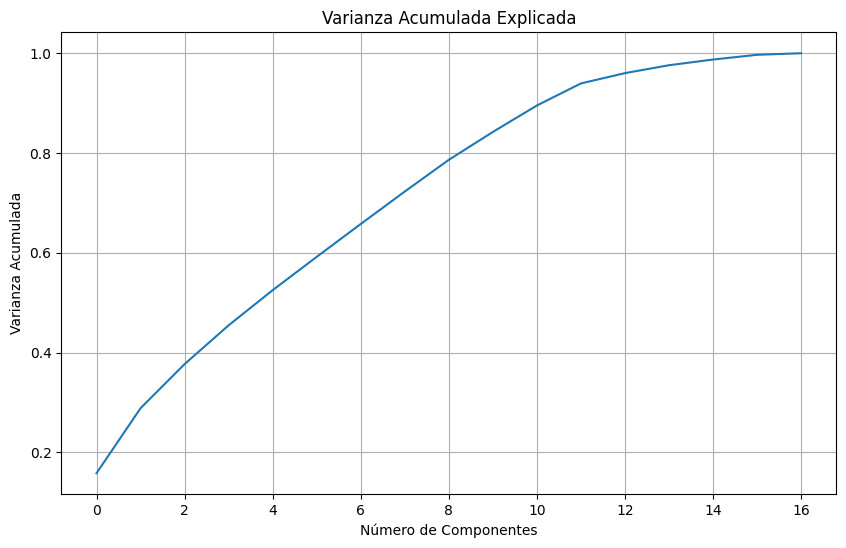

In [20]:
# 9. Gráfico adicional: Varianza explicada acumulada
# -------------------------------------------------
pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title('Varianza Acumulada Explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid()
plt.show()